# CNN CIFAR-10

## Imports

In [1]:
import os
import wandb
import torch
import torchvision
import pytorch_lightning as li
from pytorch_lightning.loggers import WandbLogger

import matplotlib.pyplot as plt
import numpy as np

In [2]:
print(f"Environment Info")

# Device
print(f" | Device: {os.uname().nodename}")

# GPU Env Info
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print(f" | MPS Device: {mps_device}")

# CPU Env Info
print(f" | CPU Threads: {torch.get_num_threads()}")

Environment Info
 | Device: mbp-von-yvo.edu.ds.fhnw.ch
 | MPS Device: mps
 | CPU Threads: 12


# Schritt 1: Auswahl Task / Datensatz 

1. Mache Dir Gedanken, mit welchen Daten Du arbeiten möchtest und welcher Task gelernt werden soll.  
2. Diskutiere die Idee mit dem Fachcoach.  


**Absprache mit Fachcoach**:

- Deadline: 20. April 2023
- Task: Klassifizierung des CIFAR-10 Datensatzes (32x32 Bilder von 10 Klassen)
- Nutzung von W&B zur Model Evaluation
- [Deep Learning Vorlesungen](https://fleuret.org/dlc/) von Francois Fleuret als Grundlage


# Schritt 2: Daten Kennenlernen 
1. Mache Dich mit dem Datensatz vertraut, indem Du eine (kurze) explorative Analyse der Features durchführst: z.B. Vergleich der Klassen pro Feature, Balanciertheit der Klassen. 
2. Führe ein geeignetes Preprocessing durch, z.B. Normalisierung der Daten.

## Load & Preprocess Dataset 

In [3]:
transform = torchvision.transforms.Compose([
    # 1. transform to pytorch Tensor, which also scales the values to [0, 1]
    torchvision.transforms.ToTensor(), 
    # 2. normalize the tensor with mean (0.5, 0.5, 0.5) and standard deviation (0.5, 0.5, 0.5) for each of the three color channels (RGB) of the image
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=9) #, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3) #, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## EDA

### Looking at some images

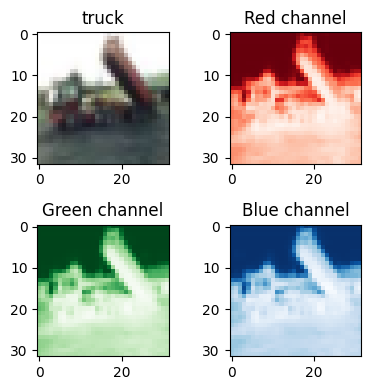

In [4]:
# plot an image from the dataset
def plot_image(id, dataset):
    img = dataset.data[id]

    fig, axs = plt.subplots(2, 2, figsize=(4, 4))
    axs = axs.flatten()

    axs[0].imshow(img)
    axs[0].set_title(dataset.classes[dataset.targets[id]])

    axs[1].imshow(img[:,:,0], cmap='Reds')
    axs[1].set_title('Red channel')

    axs[2].imshow(img[:,:,1], cmap='Greens')
    axs[2].set_title('Green channel')

    axs[3].imshow(img[:,:,2], cmap='Blues')
    axs[3].set_title('Blue channel')

    plt.tight_layout()
    plt.show()

plot_image(2, trainset)

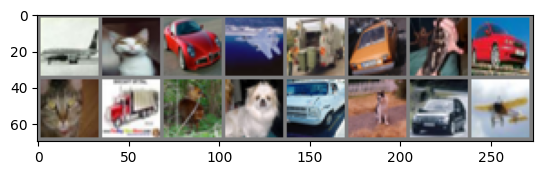

plane    cat      car      plane    truck    car      cat      car      cat      truck    deer     dog      car      cat      car      plane   


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images.to(mps_device)
labels.to(mps_device)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:8s}' for j in range(batch_size)))

### Class Distribution

As expected based on the dataset's description, the CIFAR10 dataset includes 50'000 images for each class in the training dataset and is therefore balanced.

{6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000}


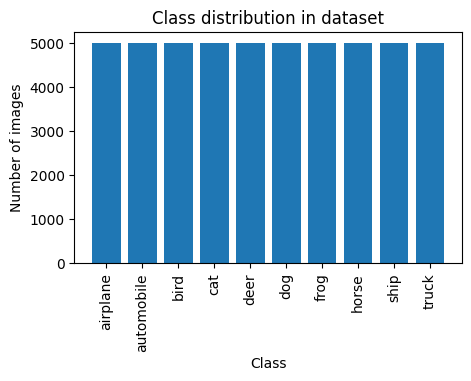

{3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000}


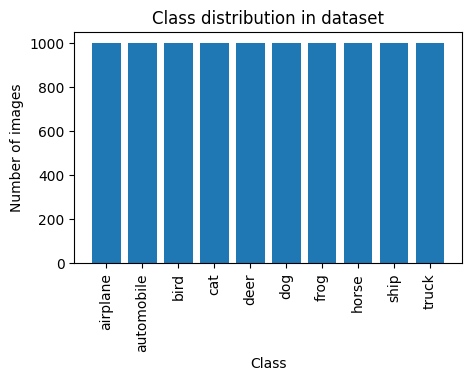

In [6]:
# Check the distribution of the classes in the training set
def show_class_distribution(dataset):
    class_count_dict = {}
    for i in range(len(dataset.targets)):
        if dataset.targets[i] in class_count_dict:
            class_count_dict[dataset.targets[i]] += 1
        else:
            class_count_dict[dataset.targets[i]] = 1
    for i in range(10):
        if i not in class_count_dict:
            class_count_dict[i] = 0

    print(class_count_dict)

    # plot bar plot with target labels
    plt.bar(range(len(class_count_dict)), list(class_count_dict.values()), align='center')
    plt.xticks(range(len(class_count_dict)), dataset.classes, rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Class distribution in dataset')

    fig = plt.gcf()
    fig.set_size_inches(5, 3)

    plt.show()

show_class_distribution(trainset)
show_class_distribution(testset)

# Schritt 3: Aufbau Modellierung

Metriken zur Evaluierung:
- Accuracy
- F1-Score

1. Lege fest, wie (mit welchen Metriken) Du Modelle evaluieren möchtest. 
Berücksichtige auch den Fehler in der Schätzung dieser Metriken.  
2. Implementiere Basisfunktionalität, um Modelle zu trainieren und gegeneinander zu 
evaluieren.  
Empfehlenswert ist die Verwendung einer geeigneten MLOps Plattform (z.B. W&B) 
3. Teste Modelle und Trainingsfunktionalität, indem Du nur mit einem einzigen Sample 
oder einem Batch trainierst. Damit bekommst Du zwar Overfitting, aber auch einen 
guten Test, der zeigt dass Information aus den Daten aufgenommen werden kann.

Komplexität/Tiefe des Modells variieren

Bei CNN: Filter Grössen variieren

Hyperparameter -> Tuning reicht bei einem Modell

## PyTorch Lightning

In [7]:
# Define the CNN architecture
class Baseline_CNN(li.LightningModule):
    def __init__(self, num_filters1=32, num_filters2=64, linear1_out=512, learning_rate=1e-3):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, num_filters1, kernel_size=(3,3), padding=1)
        self.conv2 = torch.nn.Conv2d(num_filters1, num_filters2, kernel_size=(3,3), padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(num_filters2 * 8 * 8, linear1_out)
        self.fc2 = torch.nn.Linear(linear1_out, 10)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = torch.nn.CrossEntropyLoss()(outputs, targets)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = torch.nn.CrossEntropyLoss()(outputs, targets)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

In [10]:
# Create the PyTorch Lightning trainer
def train_sweep():
    wandb.finish()

    model = Baseline_CNN(
        num_filters1=wandb.config.num_filters1,
        num_filters2=wandb.config.num_filters2,
        linear1_out=wandb.config.linear1_out,
        learning_rate=wandb.config.learning_rate,
    )

    trainer = li.Trainer(
        max_epochs=wandb.config.epochs,
        logger=WandbLogger(),
        log_every_n_steps=1000,
        enable_progress_bar=False,
        # progress_bar_refresh_rate=100,
    )

    trainer.fit(model, trainloader, testloader)

In [11]:
# Configure Weights & Biases sweeps
sweep_config = {
    "name": "cnn-sweep-test",
    "method": "grid",
    "metric": {
        "name": "val_loss",
        "goal": "minimize",
    },
    "parameters": {
        "num_filters1": {"values": [4, 8, 16]},
        "num_filters2": {"values": [4, 8, 16]},
        "linear1_out": {"values": [256, 512, 1024]},
        "learning_rate": {"values": [1e-5, 1e-4, 1e-3]},
        "epochs": {"values": [10]},
    }
}

# Initialize Weights & Biases Sweep
os.environ['WANDB_NOTEBOOK_NAME'] = 'mini-challenge-1.ipynb'

# Setup Weight & Biases
sweep_id = wandb.sweep(sweep_config, entity='yvokeller', project='deep-learning')

# Run the sweep
wandb.agent(sweep_id, function=train_sweep)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: iyybda5b
Sweep URL: https://wandb.ai/yvokeller/deep-learning/sweeps/iyybda5b


wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:               epoch ▁▁
wandb:     train_loss_step ▁█
wandb: trainer/global_step ▁█
wandb: 
wandb: Run summary:
wandb:               epoch 0
wandb:     train_loss_step 2.30058
wandb: trainer/global_step 1999
wandb: 
wandb: 🚀 View run hardy-sweep-1 at: https://wandb.ai/yvokeller/deep-learning/runs/qk39ezgs
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230406_161819-qk39ezgs/logs
wandb: Agent Starting Run: y7efqhkc with config:
wandb: 	epochs: 10
wandb: 	learning_rate: 1e-05
wandb: 	linear1_out: 256
wandb: 	num_filters1: 4
wandb: 	num_filters2: 4
Exception in thread Thread-10 (_run_job):
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/deep-learning/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "/var/folders/8s/7zgyk05565q9l208ztk8sp

Error in callback <function _WandbInit._pause_backend at 0x16a8b0430> (for post_run_cell):


# Schritt 4: Evaluation

### Testing the Model

#### Ground Truth

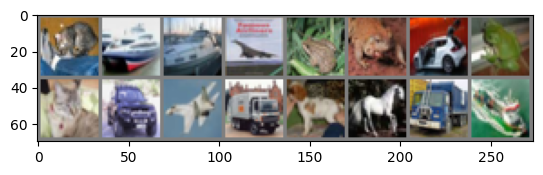

GroundTruth:  cat   ship  ship  plane


In [18]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

#### Model Prediction

In [20]:
MODEL_PATH = './cifar_net.pth'

net = Net()
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [21]:
# Predict
outputs = net(images)
outputs

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   car   ship  ship 
